In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st

from statsmodels.miscmodels.ordinal_model import OrderedModel

import arviz as az
import bambi as bmb
import pymc as pm

Earlier in my career I made a mistake while communicating results of my work.

I needed to fit an ordered logit for a model and needed to communicate the effect of variables which I did via _weight plot_, where dots represent the estimated coefficient and the lines represent its standard error. However, it was misleading because coefficients of an ordered logit model are in log-odds scale which we are, as humans, not operating under intuitively. My lowest category had very high base rate, so those _big coefficients_ weren't shifting the probability mass much.

So, what should have been done? Well, I should have pushed predictions out of the model under different values of whatever the variable that was in the interest and show the change in the distribution. Like, computing the predicted values when its at 0 vs when its at 1. Let me show you an example below.

### FREQUENTIST WAY

In [2]:
df = pd.read_csv('Trolley_data.csv', index_col=0)
df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
1,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
2,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
3,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
4,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
5,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


Are you familiar with Trolley problems? If not, you haven't been reading much ethics probably.

Trolley problems are ethical dilemmas designed in a specific way. There are various versions of it. Here's one of them:

> There's a runaway trolley and it's on a track towards five people who are tied up (they cannot escape). You're near a lever and if you pull it, the road will diverge and the trolley will hit to a person. Should you pull the lever?

This is a _dilemma_, since it puts you into a situation where either 1 person or 5 people will lose their lives. In our dataset, we have different version of these scenarios (not necessarily trolleys) where each have different features which are reflected as `action`, `intention`, and `contact` in the dataframe.

Action means the person takes an action (like pulling the lever). In the intention scenario, the person pulls the lever and once the trolley hits to the first person it stops hence does not hit the other five (if you don't, it will). In the contact version, the person pushes a guy and trolley hits the pushed person and stops. Again, stories doesn't have to be trolley; you can see the variance in the story column.

Since idea of this post is to focus on visualization, we'll move on with `action`, `intention`, and `contact`.

In [3]:
ol_m1 = OrderedModel(
    df['response'],
    df[['action', 'intention', 'contact']],
    distr='logit'
)

In [4]:
res_m1 = ol_m1.fit(method='bfgs', disp=False)
res_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               response   Log-Likelihood:                -18536.
Model:                   OrderedModel   AIC:                         3.709e+04
Method:            Maximum Likelihood   BIC:                         3.715e+04
Date:                Sun, 15 Feb 2026                                         
Time:                        22:22:14                                         
No. Observations:                9930                                         
Df Residuals:                    9921                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
action        -0.7091      0.041    -17.498      0.000      -0.789      -0.630
intention     -0.7205      0.037    -19.709      0.000      -0.792      -0.649
contact       -0.9614      0.050    -19.221      0.000      -1.059      -0.863
1/2           -2.8374      0.047    -60.363      0.000      -2.930      -2.745
2/3           -0.3829      0.032    -11.979      0.000      -0.446      -0.320
3/4           -0.5404      0.029    -18.541      0.000      -0.597      -0.483
4/5            0.0213      0.019      1.123      0.262      -0.016       0.058
5/6           -0.4032      0.025    -16.415      0.000      -0.451      -0.355
6/7           -0.0981      0.025     -3.921      0.000      -0.147      -0.049
==============================================================================
"""

Instead of relying on a table (which is almost always a bad idea, specifically in causal settings) that gives us coefficients on a scale that is not intuitive at all, let's do what has been suggested above.

In [5]:
cats = res_m1.model.labels
cats

array([1, 2, 3, 4, 5, 6, 7])

In [6]:
new_df = pd.DataFrame({
    'action':[0, 0],
    'intention':[0, 1],
    'contact':[0, 0]
})
new_df

,action,intention,contact
0,0,0,0
1,0,1,0


So we vary the intention only, while keeping action and contact fixed. I'll only do this comparison but others are valid as well.

In [7]:
df.groupby(['action', 'intention', 'contact']).size()

action  intention  contact
0       0          0          1655
                   1           993
        1          0          1986
                   1           993
1       0          0          2648
        1          0          1655
dtype: int64

In [8]:
res_m1.model.predict(res_m1.params, new_df, which='cumprob')

array([[0.05533774, 0.1038192 , 0.1717946 , 0.36552308, 0.52913695,
        0.73560502, 1.        ],
       [0.10746953, 0.19232512, 0.2989207 , 0.54216151, 0.69787495,
        0.85116506, 1.        ]])

In [9]:
preds = pd.DataFrame(res_m1.model.predict(res_m1.params, new_df, which='cumprob'))
preds

,0,1,2,3,4,5,6
0,0.055338,0.103819,0.171795,0.365523,0.529137,0.735605,1.0
1,0.107470,0.192325,0.298921,0.542162,0.697875,0.851165,1.0


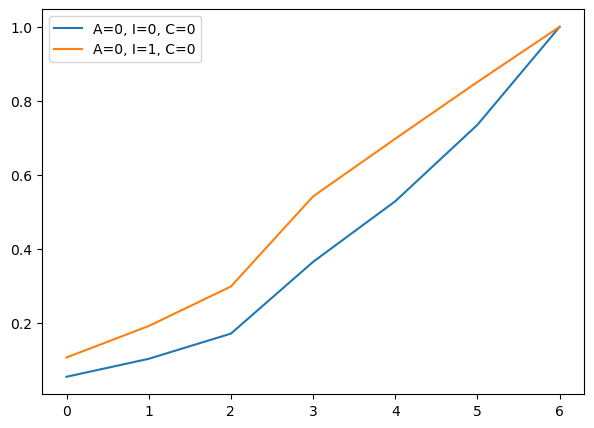

In [10]:
plt.figure(figsize=(7, 5))

plt.plot(preds.iloc[0, :], label='A=0, I=0, C=0')
plt.plot(preds.iloc[1, :], label='A=0, I=1, C=0')

plt.legend()

Same thing can be done for each possible combination and included with subplots. I just wanted to convey the idea.

If you're interested in Bayesian version, Bambi provides a very quick way to fit.

### BAYESIAN WAY

In [11]:
df = pd.read_csv('Trolley_data.csv', usecols=['response', 'action', 'intention', 'contact'])
df.head()

,response,action,intention,contact
0,4,0,0,1
1,3,0,0,1
2,4,0,0,1
3,3,0,1,1
4,3,0,1,1


In [12]:
df['response'] = pd.Categorical(df['response'], ordered=True)

In [13]:
ol_m2 = bmb.Model('response ~ action + intention + contact', data=df, family='cumulative')
idata_m2 = ol_m2.fit()

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold, action, intention, contact]


Output()

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pytensor/compile/function/types.py:992: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


In [14]:
az.summary(idata_m2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
action,-0.704,0.041,-0.779,-0.622,0.001,0.001,2613.0,2819.0,1.0
contact,-0.956,0.050,-1.054,-0.867,0.001,0.001,2731.0,3021.0,1.0
intention,-0.716,0.036,-0.784,-0.651,0.001,0.000,3179.0,2883.0,1.0
threshold[0],-2.830,0.047,-2.915,-2.742,0.001,0.001,1812.0,2499.0,1.0
threshold[1],-2.148,0.043,-2.222,-2.064,0.001,0.001,2060.0,2642.0,1.0
threshold[2],-1.565,0.039,-1.640,-1.494,0.001,0.001,2104.0,2526.0,1.0
threshold[3],-0.544,0.037,-0.615,-0.475,0.001,0.001,2308.0,2756.0,1.0
threshold[4],0.124,0.037,0.054,0.192,0.001,0.001,2524.0,3046.0,1.0
threshold[5],1.031,0.039,0.958,1.106,0.001,0.001,2949.0,3336.0,1.0


In [15]:
grid = pd.DataFrame({
    'action':    [0, 0],
    'intention': [0, 1],
    'contact':   [0, 0],
})

In [16]:
idata_pred = ol_m2.predict(idata_m2, data=grid, kind='response_params', inplace=False)

In [17]:
p = idata_pred.posterior['p']

In [18]:
ps = p.stack(sample=('chain', 'draw')).transpose('sample', '__obs__', 'response_dim')

# CDF
cdfs = ps.cumsum(dim='response_dim')

In [19]:
cdf_mean = cdfs.mean(dim='sample')
cdf_lo   = cdfs.quantile(0.055, dim='sample')
cdf_hi   = cdfs.quantile(0.945, dim='sample')

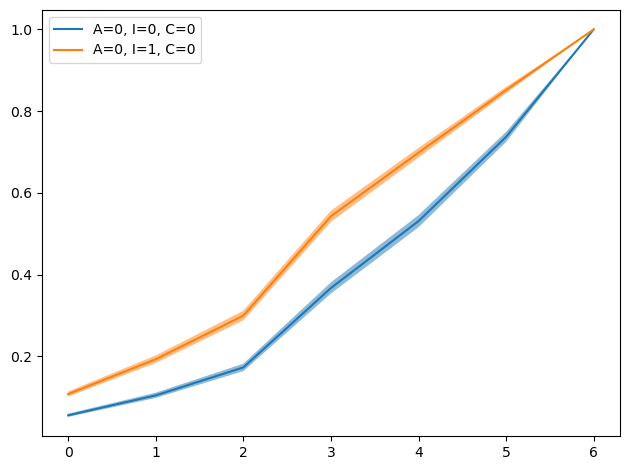

In [20]:
x = np.arange(cdf_mean.sizes['response_dim'])

labels = ['A=0, I=0, C=0', 'A=0, I=1, C=0']

for i, lab in enumerate(labels):
    y  = cdf_mean.isel(__obs__=i).values
    lo = cdf_lo.isel(__obs__=i).values
    hi = cdf_hi.isel(__obs__=i).values

    plt.plot(x, y, label=lab)
    plt.fill_between(x, lo, hi, alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()